# Capstone Three - Data Wrangling and EDA

In the final capstone for the Springboard project we are going to take another look at the second capstone; predicting monthly airbnb booking is going to be at least %50 or not. In our last capstone we were able to achieve decent accuracy, however there definitely could be some improvement. For this project we are going to be utilizing a classifier instead of linear regression to be able to predict our airbnb booking. We will be utilizing the use deep learning (tensorflow) to do this binary classifcation problem. In theory neural networks will usually perform better but they are prone to overfitting, so let's try it out. This time around since we are using deep learning technologies we will now explore the data a little differently and add more features for our neural network.

In [87]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import json
from collections import Counter

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import nltk
from fuzzywuzzy import fuzz

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
#Read the data
df = pd.read_csv("../assets/data/orig/listings.csv")
df.head()

id                        listing_url       scrape_id last_scraped  \
0  5456  https://www.airbnb.com/rooms/5456  20220312074014   2022-03-13   
1  5769  https://www.airbnb.com/rooms/5769  20220312074014   2022-03-31   
2  6413  https://www.airbnb.com/rooms/6413  20220312074014   2022-03-31   
3  6448  https://www.airbnb.com/rooms/6448  20220312074014   2022-03-12   
4  8502  https://www.airbnb.com/rooms/8502  20220312074014   2022-03-13   

                                                name  \
0          Walk to 6th, Rainey St and Convention Ctr   
1                                     NW Austin Room   
2                      Gem of a Studio near Downtown   
3  Secluded Studio @ Zilker - King Bed, Bright & ...   
4                            Woodland Studio Lodging   

                                         description  \
0  Great central  location for walking to Convent...   
1  <b>The space</b><br />Looking for a comfortabl...   
2  Great studio apartment, perfect a single perso...   
3  Clean, private space with everything you need ...   
4  <b>The space</b><br />Fully furnished suite wi...   

                               neighborhood_overview  \
0  My neighborhood is ideally located if you want...   
1  Quiet neighborhood with lots of trees and good...   
2  Travis Heights is one of the oldest neighborho...   
3  The neighborhood is fun and funky (but quiet)!...   
4                                                NaN   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/14084884/b5a3...     8028   
1  https://a0.muscache.com/pictures/23822033/ac94...     8186   
2  https://a0.muscache.com/pictures/miso/Hosting-...    13879   
3  https://a0.muscache.com/pictures/4513152/4ffc1...    14156   
4  https://a0.muscache.com/pictures/miso/Hosting-...    25298   

                                  host_url  ... review_scores_communication  \
0   https://www.airbnb.com/users/show/8028  ...                        4.81   
1   https://www.airbnb.com/users/show/8186  ...                        4.94   
2  https://www.airbnb.com/users/show/13879  ...                        4.98   
3  https://www.airbnb.com/users/show/14156  ...                        4.97   
4  https://www.airbnb.com/users/show/25298  ...                        4.86   

  review_scores_location review_scores_value license instant_bookable  \
0                   4.73                4.78     NaN                f   
1                   4.74                4.92     NaN                f   
2                   4.86                4.94     NaN                t   
3                   4.97                4.89     NaN                t   
4                   4.64                4.57     NaN                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                              1                                           1   
1                              1                                           0   
2                              1                                           1   
3                              1                                           1   
4                              1                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            1   
2                                            0   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              3.69  
1                                           0              1.81  
2                                           0              0.78  
3                                           0              2.09  
4                                           0              0.33  

[5 rows x 74 columns]

Great we have the data imported the next thing we are going to do is check to see if there are any data that are null/corrupted and get a count in the dataframe

In [4]:
df.isna().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                                0
description                                       164
neighborhood_overview                            4913
picture_url                                         1
host_id                                             0
host_url                                            0
host_name                                           3
host_since                                          3
host_location                                      18
host_about                                       4679
host_response_time                               3449
host_response_rate                               3449
host_acceptance_rate                             2862
host_is_superhost                                   3
host_thumbnail_url          

There seems to be a considerable amount of missing data from some of these columns. I think we can move in the right direction by first only selecting the columns that we will be using for our modeling.

In [5]:
list(df.columns)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30',
 'availa

In [6]:
selected_features = [
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_since',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'latitude',
 'longitude',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'reviews_per_month']
 
df_feature_subset = df[selected_features]
df_feature_subset.head()

name  \
0          Walk to 6th, Rainey St and Convention Ctr   
1                                     NW Austin Room   
2                      Gem of a Studio near Downtown   
3  Secluded Studio @ Zilker - King Bed, Bright & ...   
4                            Woodland Studio Lodging   

                                         description  \
0  Great central  location for walking to Convent...   
1  <b>The space</b><br />Looking for a comfortabl...   
2  Great studio apartment, perfect a single perso...   
3  Clean, private space with everything you need ...   
4  <b>The space</b><br />Fully furnished suite wi...   

                               neighborhood_overview  \
0  My neighborhood is ideally located if you want...   
1  Quiet neighborhood with lots of trees and good...   
2  Travis Heights is one of the oldest neighborho...   
3  The neighborhood is fun and funky (but quiet)!...   
4                                                NaN   

                                         picture_url  host_since  \
0  https://a0.muscache.com/pictures/14084884/b5a3...  2009-02-16   
1  https://a0.muscache.com/pictures/23822033/ac94...  2009-02-19   
2  https://a0.muscache.com/pictures/miso/Hosting-...  2009-04-17   
3  https://a0.muscache.com/pictures/4513152/4ffc1...  2009-04-20   
4  https://a0.muscache.com/pictures/miso/Hosting-...  2009-07-11   

                                          host_about host_response_time  \
0  I am a licensed Real Estate Broker and owner o...     within an hour   
1  We're easygoing professionals that enjoy meeti...                NaN   
2  We're a young family that likes to travel, we ...     within an hour   
3  We are a family of four (with teenagers, all o...     within an hour   
4  I handle the reservations at the studio on the...       within a day   

  host_response_rate host_acceptance_rate host_is_superhost  ...  \
0               100%                  94%                 t  ...   
1                NaN                 100%                 t  ...   
2               100%                 100%                 t  ...   
3               100%                  98%                 t  ...   
4                83%                  29%                 f  ...   

   number_of_reviews_l30d  last_review review_scores_rating  \
0                       5   2022-03-07                 4.83   
1                       0   2021-07-03                 4.90   
2                       0   2021-07-01                 4.97   
3                       3   2022-03-06                 4.97   
4                       0   2021-11-13                 4.53   

  review_scores_accuracy instant_bookable  calculated_host_listings_count  \
0                   4.87                f                               1   
1                   4.90                f                               1   
2                   4.99                t                               1   
3                   4.97                t                               1   
4                   4.49                f                               1   

  calculated_host_listings_count_entire_homes  \
0                                           1   
1                                           0   
2                                           1   
3                                           1   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            1   
2                                            0   
3                                            0   
4                                            0   

   calculated_host_listings_count_shared_rooms reviews_per_month  
0                                            0              3.69  
1                                            0              1.81  
2                                            0              0.78  
3                                            0              2.

Ok we now have a subset of the data. Let's look at the number of null values again.

In [7]:
df_feature_subset.isna().sum().sort_values(ascending=False)

neighbourhood                                   4913
neighborhood_overview                           4913
host_about                                      4679
host_response_time                              3449
host_response_rate                              3449
review_scores_accuracy                          3018
last_review                                     2946
review_scores_rating                            2946
reviews_per_month                               2946
host_acceptance_rate                            2862
bedrooms                                         711
description                                      164
beds                                             150
bathrooms_text                                    16
host_listings_count                                3
host_since                                         3
host_is_superhost                                  3
host_identity_verified                             3
host_has_profile_pic                          

As a mental note after looking at the data it would probably make sense to eliminate records that don't have any availability and have at least 3.0 in review score rating. Going to explore that notion a little later in the EDA portion.

Let's start taking further look into the missing values and see if perhaps we can impute a value for some of these missing values for these columns

In [8]:
df_feature_subset['neighbourhood'].value_counts()

Austin, Texas, United States                    6943
Lakeway, Texas, United States                     29
West Lake Hills, Texas, United States             14
Dripping Springs, Texas, United States            14
Sunset Valley, Texas, United States                8
Manchaca, Texas, United States                     6
Round Rock, Texas, United States                   5
Leander, Texas, United States                      5
The Hills, Texas, United States                    4
Pflugerville, Texas, United States                 4
Bee Cave, Texas, United States                     3
Del Valle, Texas, United States                    3
Austin, United States                              2
Cedar Park, Texas, United States                   2
Buda, Texas, United States                         2
Lago Vista, Texas, United States                   2
Austin , Texas, United States                      2
United States                                      1
Rollingwood, Texas, United States             

In [9]:
df_feature_subset['neighbourhood'] = df_feature_subset['neighbourhood'].fillna("United States")

/tmp/ipykernel_10322/64469016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['neighbourhood'] = df_feature_subset['neighbourhood'].fillna("United States")


In [10]:
df_feature_subset['neighbourhood'].value_counts()

Austin, Texas, United States                    6943
United States                                   4914
Lakeway, Texas, United States                     29
West Lake Hills, Texas, United States             14
Dripping Springs, Texas, United States            14
Sunset Valley, Texas, United States                8
Manchaca, Texas, United States                     6
Round Rock, Texas, United States                   5
Leander, Texas, United States                      5
The Hills, Texas, United States                    4
Pflugerville, Texas, United States                 4
Bee Cave, Texas, United States                     3
Del Valle, Texas, United States                    3
Lago Vista, Texas, United States                   2
Austin , Texas, United States                      2
Austin, United States                              2
Buda, Texas, United States                         2
Cedar Park, Texas, United States                   2
Austin, Tx, United States                     

Upon looking at the csv file for the neighbourhood_overview field it is essentially a descriptive text field I think I will fill those missing values for this column with an empty string ''

In [11]:
df_feature_subset['neighborhood_overview'] = df_feature_subset['neighborhood_overview'].fillna('')

/tmp/ipykernel_10322/1089897637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['neighborhood_overview'] = df_feature_subset['neighborhood_overview'].fillna('')


Let's also do the same thing for the host_about field as well.

In [12]:
df_feature_subset['host_about'] = df_feature_subset['host_about'].fillna('')

/tmp/ipykernel_10322/1195375826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['host_about'] = df_feature_subset['host_about'].fillna('')


Looking at the possible values for the host_response_time field in the data it appears that 'N/A' is an acceptable value perhaps we can use that as well in place of the nan values for this column. Let's do that.

In [13]:
df_feature_subset['host_response_time'].value_counts()

within an hour        6835
within a few hours     957
within a day           610
a few days or more     121
Name: host_response_time, dtype: int64

In [14]:
df_feature_subset['host_response_time'] = df_feature_subset['host_response_time'].fillna("N/A")

/tmp/ipykernel_10322/2801879920.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['host_response_time'] = df_feature_subset['host_response_time'].fillna("N/A")


Looking at the host_response_rate which is a percentage but datatype is a string we can convert to a numeric value and the values of 'N/A' can probably be converted into a negative percentage. As an aside we can probably drop the missing data values but after we perform our data analysis.

In [166]:
def updateToDecimal(attribute):
    if attribute == 'N/A':
      return -1
    else:
        numerica_val = int(attribute.split("%")[0]) * .01
        return numerica_val

In [15]:

df_feature_subset['host_response_rate'] = df_feature_subset['host_response_rate'].fillna("N/A")
df_feature_subset['host_response_rate_percent'] = df_feature_subset['host_response_rate'].apply(updateToDecimal)

/tmp/ipykernel_10322/1084646869.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['host_response_rate'] = df_feature_subset['host_response_rate'].fillna("N/A")
/tmp/ipykernel_10322/1084646869.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['host_response_rate_percent'] = df_feature_subset['host_response_rate'].apply(updateToDecimal)


<AxesSubplot:>

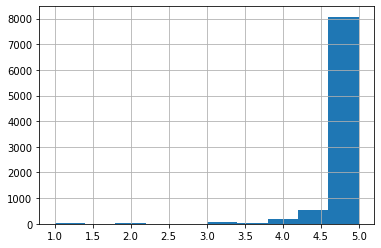

In [16]:
df_feature_subset['review_scores_accuracy'].hist()

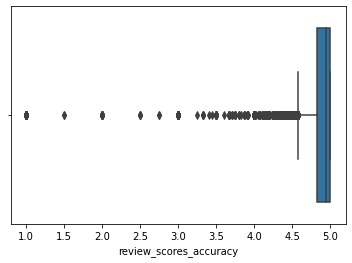

In [17]:
ax = sns.boxplot(x=df_feature_subset['review_scores_accuracy'])

In [18]:
df_feature_subset['review_scores_accuracy'].median()

4.95

With the missing values for the review_scores_accuracy we will fill  that with the median value for this field which is 4.95

In [19]:
df_feature_subset['review_scores_accuracy'] = df_feature_subset['review_scores_accuracy'].fillna(4.95)

/tmp/ipykernel_10322/4079742589.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['review_scores_accuracy'] = df_feature_subset['review_scores_accuracy'].fillna(4.95)


In [20]:
df_feature_subset['last_review'].describe()

count           9026
unique          1273
top       2022-03-06
freq             598
Name: last_review, dtype: object

I think we can drop this column it doesn't pertain information that will be useful for our objective of predicting airbnb_booking rates. Let's also do that for reviews_per_month and host_acceptance_rate

In [21]:
df_feature_subset.drop(columns=['last_review', 'reviews_per_month', 'host_acceptance_rate'], inplace=True)

/tmp/ipykernel_10322/2532484281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['last_review', 'reviews_per_month', 'host_acceptance_rate'], inplace=True)


Let's see how the review_scores_rating data is spread out

<AxesSubplot:>

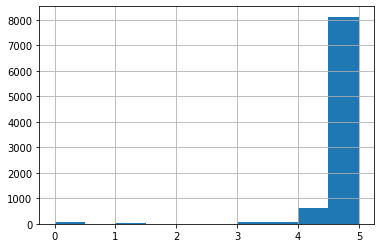

In [22]:
df_feature_subset['review_scores_rating'].hist()

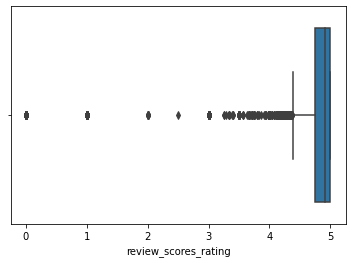

In [23]:
ax = sns.boxplot(x=df_feature_subset['review_scores_rating'])

Seems very similiar to the review_scores accuracy perhaps we can do without this field as well let's go ahead and remove it from our data.

In [24]:
df_feature_subset.drop(columns=['review_scores_rating'], inplace=True)

/tmp/ipykernel_10322/3042065733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['review_scores_rating'], inplace=True)


Let's view the nan values again for our dataframe to see how we are faring before moving forward

In [25]:
df_feature_subset.isna().sum().sort_values(ascending=False)

bedrooms                                        711
description                                     164
beds                                            150
bathrooms_text                                   16
host_is_superhost                                 3
host_identity_verified                            3
host_has_profile_pic                              3
host_listings_count                               3
host_total_listings_count                         3
host_since                                        3
minimum_minimum_nights                            1
maximum_minimum_nights                            1
minimum_maximum_nights                            1
picture_url                                       1
maximum_nights_avg_ntm                            1
maximum_maximum_nights                            1
minimum_nights_avg_ntm                            1
has_availability                                  0
availability_30                                   0
availability

Let's take one last look at the last significant null value count column which is bedrooms. Based on the spread we can either fill the missing values with a median or get rid of it all together.

In [26]:
df_feature_subset['bedrooms'].dtype

dtype('float64')

<AxesSubplot:>

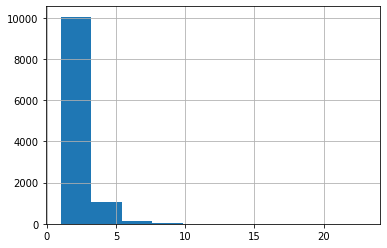

In [27]:
df_feature_subset['bedrooms'].hist()

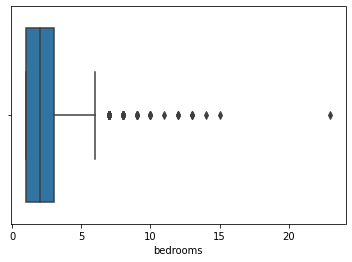

In [28]:
ax = sns.boxplot(x=df_feature_subset['bedrooms'])

Interesting spread of data we I think its safe to say that we can assign the missing data with the median value and test it out.

In [29]:
bedroom_median = df_feature_subset['bedrooms'].median()
df_feature_subset['bedrooms'] = df_feature_subset['bedrooms'].fillna(bedroom_median)

/tmp/ipykernel_10322/926673265.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['bedrooms'] = df_feature_subset['bedrooms'].fillna(bedroom_median)


In [30]:
#Check the null values again
df_feature_subset.isna().sum().sort_values(ascending=False)

description                                     164
beds                                            150
bathrooms_text                                   16
host_total_listings_count                         3
host_has_profile_pic                              3
host_since                                        3
host_identity_verified                            3
host_is_superhost                                 3
host_listings_count                               3
minimum_nights_avg_ntm                            1
maximum_maximum_nights                            1
maximum_nights_avg_ntm                            1
minimum_minimum_nights                            1
maximum_minimum_nights                            1
picture_url                                       1
minimum_maximum_nights                            1
availability_90                                   0
has_availability                                  0
availability_30                                   0
availability

Let's go ahead and drop the other data that is missing from our data frame

In [31]:
df_feature_subset.dropna(inplace=True)

/tmp/ipykernel_10322/1720193771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.dropna(inplace=True)


In [32]:
df_feature_subset.isna().sum().sort_values(ascending=False)

name                                            0
description                                     0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0
has_availability                                0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
number_of_reviews_l30d                          0
review_scores_accuracy                          0
instant_bookable                                0
calculated_host_listings_count                  0


In [33]:
df_feature_subset.shape

(11652, 48)

Fantastic! We were able to do a preliminary cleaning of the data and lost only a few records in the process next we are going to do some further data cleaning and wrangling to see how we can better refine it.

## Converting the data into a usable form for our Models

In this section we are going to combine a little of EDA into our data wrangling and look into ways of how we can transform the values into numeric values that can be interepreted by the neural network

In [34]:
df_feature_subset.dtypes

name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_since                                       object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_is_superhost                                object
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                             object
host_identity_verified                           object
neighbourhood                                    object
neighbourhood_cleansed                            int64
property_type                                    object
room_type                                        object
accommodates                                    

I think for the majority of our object data types for this dataframe we can further transform into meaningful representations such as the following:

**Drop neighbourhood_cleansed

-name,description, neighbourhood_overview, host_about -> extract text find patterns of reoccuring words that are associated with our desired target (>= 50% airbnb occupancy) and then create a one hot encoding of these words as additional features

-picture_url -> run this through a CNN for object detection and extract the relevant objects detected in the picture and similiar to the text features above find correlating pattern of objects associated with our desired target and create one hot encoded variables for this data as well.

-host_response_time -> its usually wihtin a days time so let's convert it to hours (1 - 24 hours)

-host_response_rate -> convert to a percentage (acutally there is a column created host_response_rate_percent; so we can drop this column)

-host_since -> Convert to epoch timestamp

-host_listing_count -> convert to numeric value (integer)

-host_is_superhost, host_has_profile_pic, host_identify_verified, instant_bookable, has_availability -> convert to boolean flags

-property_type, room_type, amenities - look for common patterns associated with desired target variable and one_hot encode those patterns from these features

In [35]:
df_feature_subset.drop(columns=['neighbourhood_cleansed'], inplace=True)

/tmp/ipykernel_10322/2829250649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['neighbourhood_cleansed'], inplace=True)


In [36]:
df_feature_subset.columns

Index(['name', 'description', 'neighborhood_overview', 'picture_url',
       'host_since', 'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'latitude', 'longitude', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_accuracy', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
 

Remember our objective was to be able to predict if our airbnb will have 50% booking or not, let's create our target variable to be able to do this.

In [37]:
def is_optimally_booked(attribute):
    booking_availability_percentage = attribute / 30
    return 0 if booking_availability_percentage < .5 else 1
#Let create our target variable in the dataframe
df_feature_subset['50_percent_or_more_booking'] = df_feature_subset['availability_30'].apply(is_optimally_booked)

/tmp/ipykernel_10322/536319641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['50_percent_or_more_booking'] = df_feature_subset['availability_30'].apply(is_optimally_booked)


In [38]:
df_feature_subset['50_percent_or_more_booking']

0        0
1        0
2        0
3        0
4        0
        ..
11967    1
11968    1
11969    1
11970    1
11971    1
Name: 50_percent_or_more_booking, Length: 11652, dtype: int64

Next we are going to split the data into two dataframes one with our optimal goal and the other not optimal. Afterwards we are going to do a visualization of the data using word clouds to see what are the frequent words that appear for each of these descriptive fields.

In [39]:
df_is_optimal_booking = df_feature_subset.loc[df_feature_subset['50_percent_or_more_booking'] == 1]
df_non_optimal_booking = df_feature_subset.loc[df_feature_subset['50_percent_or_more_booking'] == 0]

In [67]:
def create_word_cloud(df, attr, collac=False):
    #Let's look at a word cloud for the description see what words are occurring the most
    exclude_list = ['<b>', '</b>', '<br />']#exclude special characters
    text = " ".join(word for word in df[attr] if not pd.isna(word))
    for exclude_char in exclude_list:
        text = text.replace(exclude_char, '')
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=collac, collocation_threshold=3).generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Wordcloud for Name

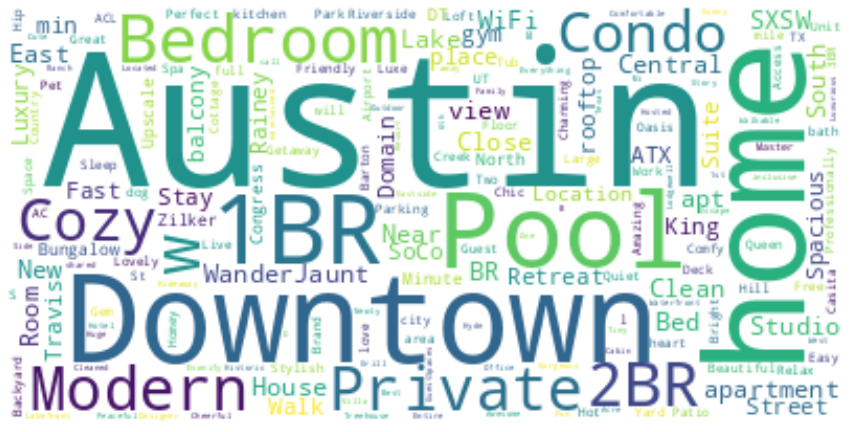

In [53]:
create_word_cloud(df_is_optimal_booking, 'name')

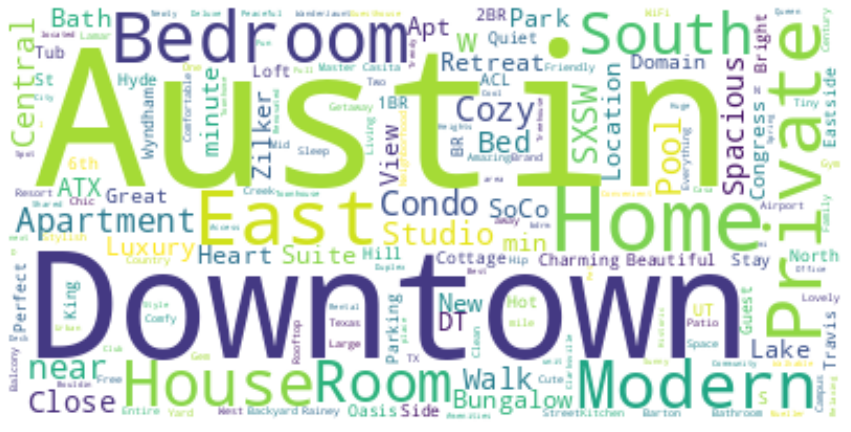

In [54]:
create_word_cloud(df_non_optimal_booking, 'name')

Wordcloud for Description

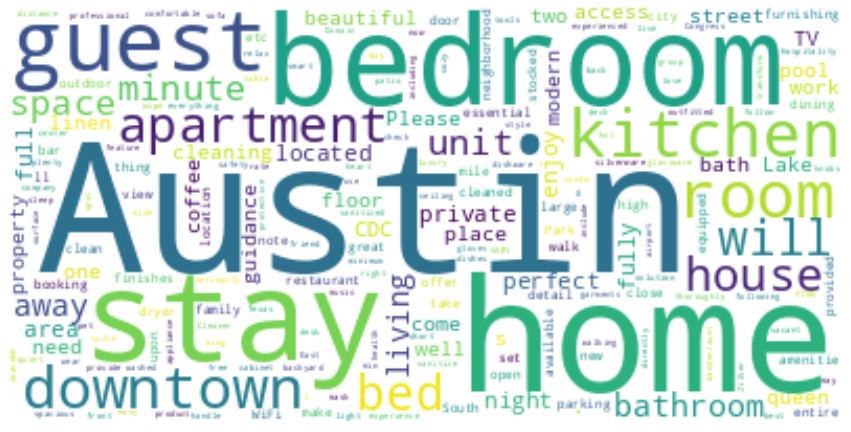

In [55]:
create_word_cloud(df_is_optimal_booking, 'description')

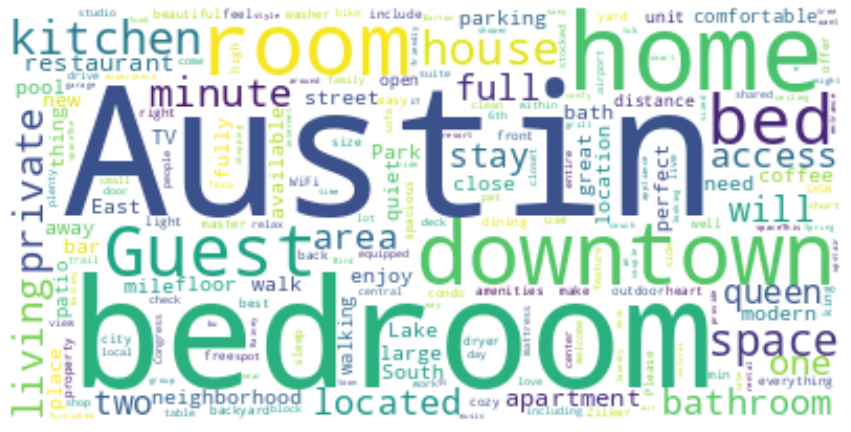

In [56]:
create_word_cloud(df_non_optimal_booking, 'description')

Wordcloud for Neighbourhood_overview

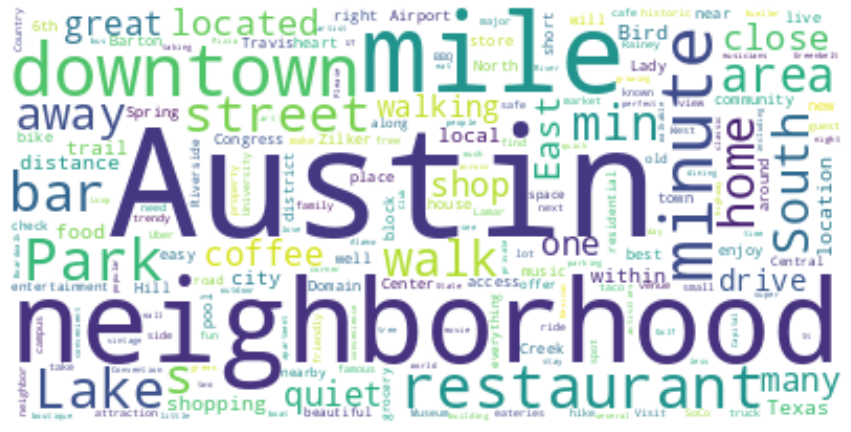

In [57]:
create_word_cloud(df_is_optimal_booking, 'neighborhood_overview')

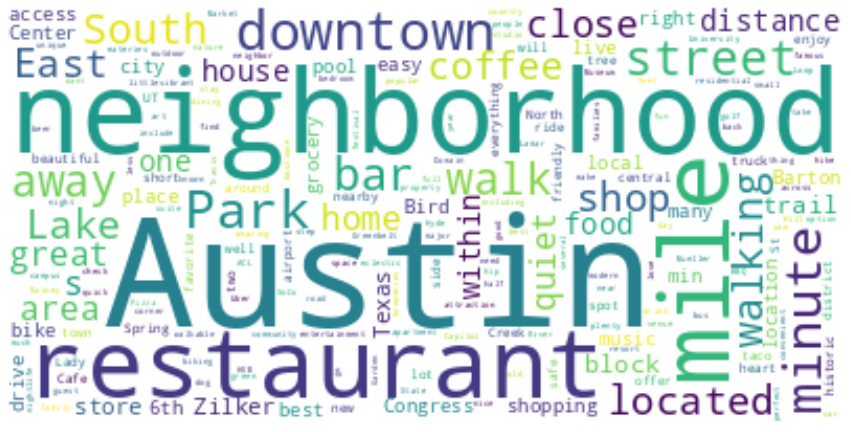

In [58]:
create_word_cloud(df_non_optimal_booking, 'neighborhood_overview')

Wordcloud for host about

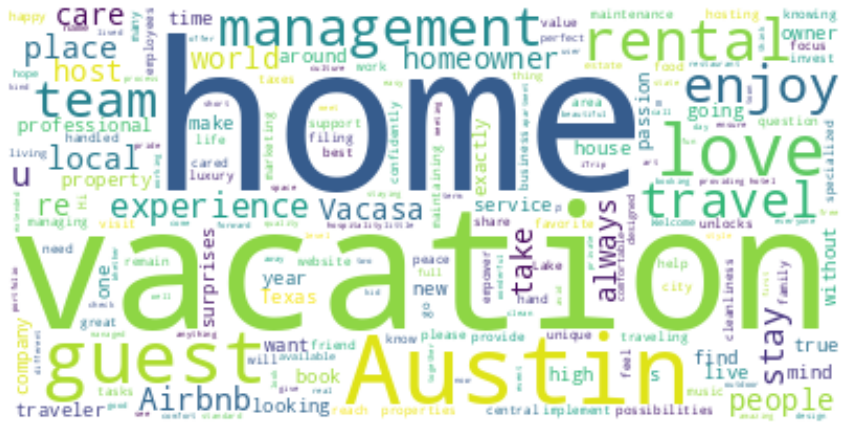

In [59]:
create_word_cloud(df_is_optimal_booking, 'host_about')

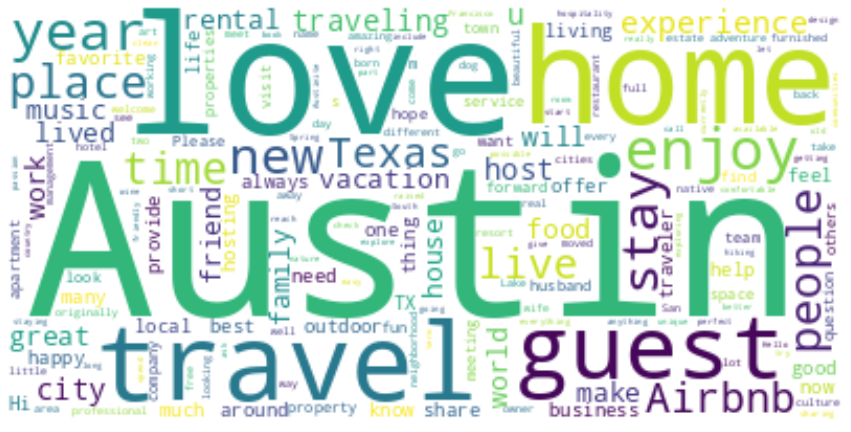

In [60]:
create_word_cloud(df_non_optimal_booking, 'host_about')

I think we found some interesting words that surfaced at the top regarding frequency but I think perhaps we can get some more insight if we incrawse our ngram count from one word to two words.

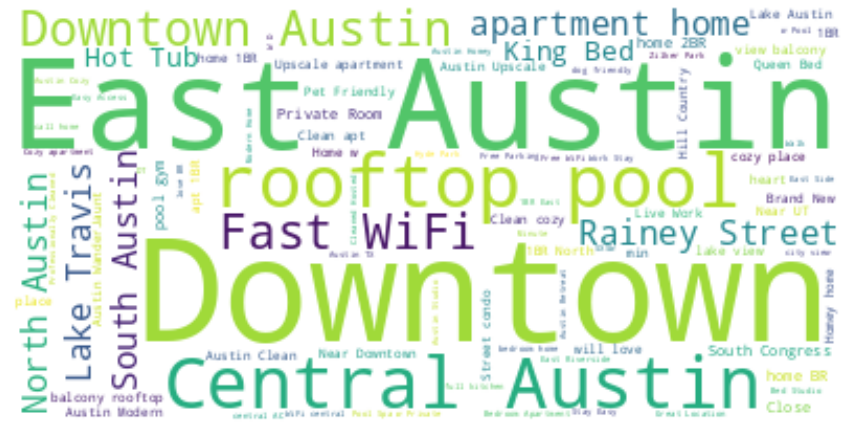

In [68]:
create_word_cloud(df_is_optimal_booking, 'name', collac=True)

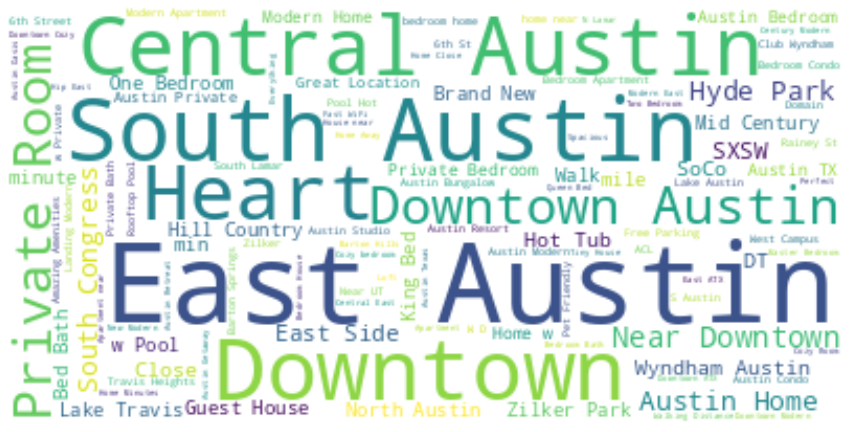

In [69]:
create_word_cloud(df_non_optimal_booking, 'name', collac=True)

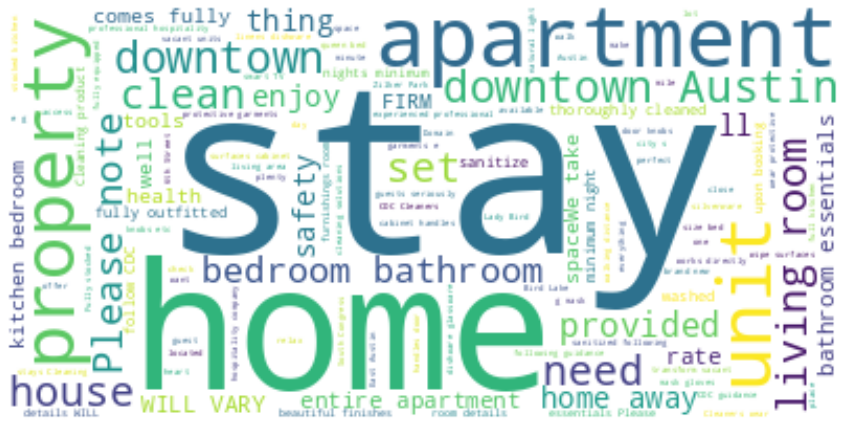

In [70]:
create_word_cloud(df_is_optimal_booking, 'description', collac=True)

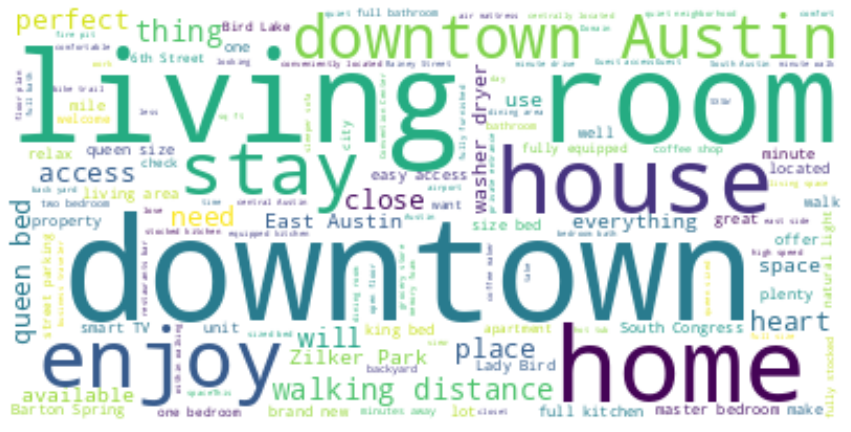

In [71]:
create_word_cloud(df_non_optimal_booking, 'description', collac=True)

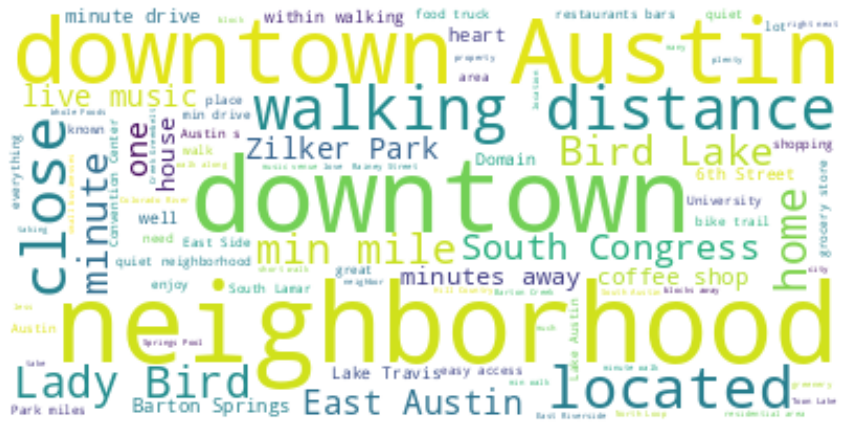

In [72]:
create_word_cloud(df_is_optimal_booking, 'neighborhood_overview', collac=True)

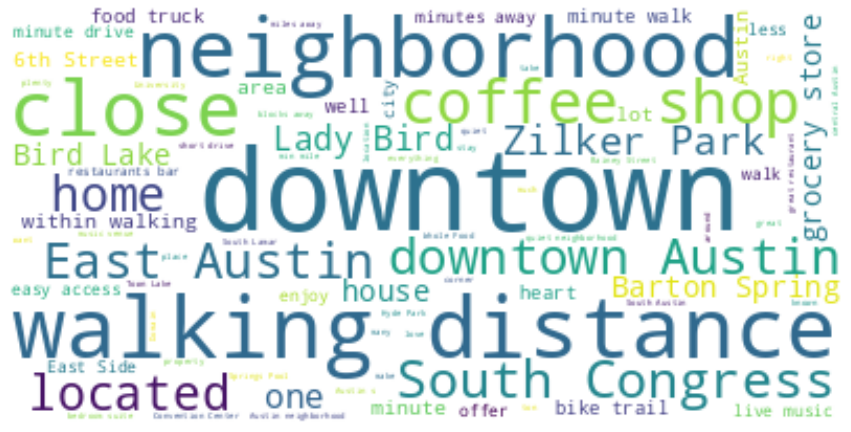

In [73]:
create_word_cloud(df_non_optimal_booking, 'neighborhood_overview', collac=True)

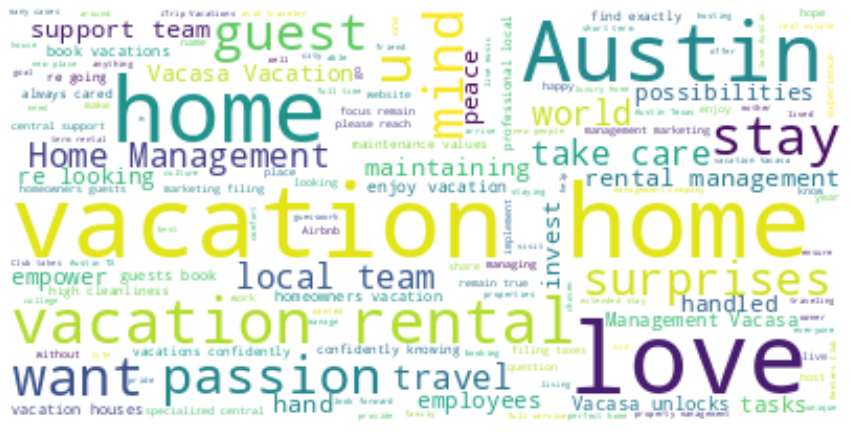

In [74]:
create_word_cloud(df_is_optimal_booking, 'host_about', collac=True)

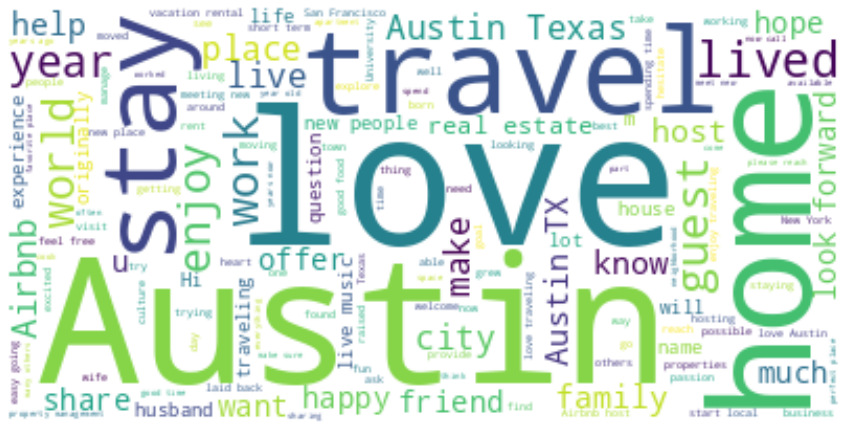

In [75]:
create_word_cloud(df_non_optimal_booking, 'host_about', collac=True)

That's a little better I think we have phrases that certainly gives us a better picture of how these two dataframes differ. As expected Location is king but there are also some ohter interesting insights that almost slid under the radar as well. Such as the name of the airbnb for the optimally booked airbnb seems to include information that are eye catches such as amenities.

### Word Frequency using NLTK and Fuzzy Matching

There are several techniques to viewing word frequence and for our amenties, property type and room types to see what are the words that stand out the most, and we will do fuzzy matching to ensure that we can create additional fields using one hot encoding for the top (10) amenities.

In [91]:
df_is_optimal_booking.shape

(2917, 48)

In [92]:
df_non_optimal_booking.shape

(8735, 48)

In [138]:
#aggregate the amenities for the two dataframes into their respective paragraphs
amenities_optimal_booking_list = list(df_is_optimal_booking['amenities'])
amenities_optimal_booking_list = list(map(lambda x: json.loads(x), amenities_optimal_booking_list))
amenities_optimal_booking_text = " ".join([". ".join(amenities_str) for amenities_str in amenities_optimal_booking_list])

In [139]:
amenities_nonoptimal_booking_list = list(df_non_optimal_booking['amenities'])
amenities_nonoptimal_booking_list = list(map(lambda x: json.loads(x), amenities_nonoptimal_booking_list))
amenities_nonoptimal_booking_text = " ".join([". ".join(amenities_str) for amenities_str in amenities_nonoptimal_booking_list])

In [77]:
#Download text sentence tokenizer and stopwords from nltk library
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mgfos207/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/mgfos207/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [78]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

In [95]:
tokenized_sent = nltk.sent_tokenize(amenities_optimal_booking_text)
optimal_filtered_sentence = [sent.replace(".", "") for sent in tokenized_sent]

In [96]:
tokenized_sent = nltk.sent_tokenize(amenities_nonoptimal_booking_text)
nonoptimal_filtered_sentence = [sent.replace(".", "") for sent in tokenized_sent]

In [97]:
optimal_amenities_counter = Counter(optimal_filtered_sentence)
nonoptimal_amenities_counter = Counter(nonoptimal_filtered_sentence)

In [98]:
optimal_amenities_counter.most_common(10)

[('Wifi', 2799),
 ('Long term stays allowed', 2581),
 ('Smoke alarm', 2530),
 ('Kitchen', 2438),
 ('Essentials', 2388),
 ('Air conditioning', 2378),
 ('Hair dryer', 2351),
 ('Shampoo', 2288),
 ('Hangers', 2274),
 ('Iron', 2248)]

In [99]:
nonoptimal_amenities_counter.most_common(10)

[('Wifi', 8299),
 ('Air conditioning', 8060),
 ('Smoke alarm', 7697),
 ('Free parking on premises', 6772),
 ('Long term stays allowed', 6724),
 ('Essentials', 6707),
 ('Heating', 6456),
 ('Washer', 6394),
 ('Shampoo', 6344),
 ('Hair dryer', 6263)]

There are some similiarities between the two let's merge them together and use that for one hot encoding for the amenities.

In [100]:
top_amenities_set = set()
optimal_amenities_set = set([common_word[0] for common_word in optimal_amenities_counter.most_common(10)])
nonoptimal_amenties_set = set([common_word[0] for common_word in nonoptimal_amenities_counter.most_common(10)])
top_amenities_set = optimal_amenities_set.union(nonoptimal_amenties_set)

top_amenities_set

{'Air conditioning',
 'Essentials',
 'Free parking on premises',
 'Hair dryer',
 'Hangers',
 'Heating',
 'Iron',
 'Kitchen',
 'Long term stays allowed',
 'Shampoo',
 'Smoke alarm',
 'Washer',
 'Wifi'}

In [144]:
#Fuzzy matching
#Iterate over each of the top amenties and create one hot encoded columns
def _find_fuzzy_match(amenities_list, amenity):
    parsed_amenities_list = json.loads(amenities_list)
    for amenity_text in parsed_amenities_list:
        if fuzz.ratio(amenity.lower(), amenity_text.lower()) >= 85:
            return 1
    return 0

for amenity in top_amenities_set:
    df_feature_subset[f'has_{amenity.lower()}'] = df_feature_subset['amenities'].apply(lambda x: _find_fuzzy_match(x, amenity))

/tmp/ipykernel_10322/2827278505.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset[f'has_{amenity.lower()}'] = df_feature_subset['amenities'].apply(lambda x: _find_fuzzy_match(x, amenity))
/tmp/ipykernel_10322/2827278505.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset[f'has_{amenity.lower()}'] = df_feature_subset['amenities'].apply(lambda x: _find_fuzzy_match(x, amenity))
/tmp/ipykernel_10322/2827278505.py:11: SettingWithCopyWarning: 
A value is trying to be set on

In [145]:
df_feature_subset.columns

Index(['name', 'description', 'neighborhood_overview', 'picture_url',
       'host_since', 'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'property_type', 'room_type', 'accommodates', 'bathrooms_text',
       'latitude', 'longitude', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_accuracy', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
 

In [146]:
#Drop redundant amenities column
df_feature_subset.drop(columns=['amenities'], inplace=True)

/tmp/ipykernel_10322/3151857365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['amenities'], inplace=True)


Picking up from our last time looking at the data we gleaned that most property types that are successful are offering entire space versus a private portion of the residence. Let's apply the same thing here for our data.

In [147]:
import re

In [149]:
def _match_property_type_entire_space(prop_type):
    entire_space = bool(re.search('Entire', prop_type, re.IGNORECASE))
    return 1 if entire_space else 0

In [150]:
df_feature_subset['entire_space'] = df_feature_subset['property_type'].apply(_match_property_type_entire_space)

/tmp/ipykernel_10322/1800255235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['entire_space'] = df_feature_subset['property_type'].apply(_match_property_type_entire_space)


In [152]:
df_feature_subset.drop(columns=['property_type'], inplace=True)

/tmp/ipykernel_10322/172344808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['property_type'], inplace=True)


In [153]:
df_feature_subset.columns

Index(['name', 'description', 'neighborhood_overview', 'picture_url',
       'host_since', 'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'room_type', 'accommodates', 'bathrooms_text', 'latitude', 'longitude',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_accuracy', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count

After looking at the long text fields such as name, description and neighborhood overview it appears that they mainly highlight location and amenities and room details all of which we can glean from the other fields in the data, so let's drop those columns.

In [154]:
df_feature_subset.drop(columns=['name', 'description', 'neighborhood_overview'], inplace=True)

/tmp/ipykernel_10322/2778044314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['name', 'description', 'neighborhood_overview'], inplace=True)


In [163]:
df_feature_subset.drop(columns=['host_about'], inplace=True)

/tmp/ipykernel_10322/611662208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['host_about'], inplace=True)


In [164]:
df_feature_subset.drop(columns=['host_response_rate'], inplace=True)

/tmp/ipykernel_10322/3717777679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['host_response_rate'], inplace=True)


In [155]:
df_feature_subset.columns

Index(['picture_url', 'host_since', 'host_about', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'room_type', 'accommodates',
       'bathrooms_text', 'latitude', 'longitude', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_accuracy', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listing

Let's now knockout some of the low hanging fruits to update some of the columns to be numeric values prior to getting to the picture_url column to extract relevant object tags for the pictures.

In [156]:
def convert_to_binary_value(attr):
    return 1 if attr.lower() == 't' else 0

binary_features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
for feature in binary_features:
    df_feature_subset[feature] = df_feature_subset[feature].apply(convert_to_binary_value)

/tmp/ipykernel_10322/1433683019.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset[feature] = df_feature_subset[feature].apply(convert_to_binary_value)


Next we'll go ahead and update the host_since to be a epoch timestamp and create a new column called 'host_since_epoch'

In [157]:
import time
import datetime

In [158]:
def convert_date_to_timestamp(date_str):
    timestamp = time.mktime(datetime.datetime.strptime(date_str,
                                             "%Y-%m-%d").timetuple())
    return timestamp

df_feature_subset['host_since_timestamp'] = df_feature_subset['host_since'].apply(convert_date_to_timestamp)

/tmp/ipykernel_10322/3308857424.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset['host_since_timestamp'] = df_feature_subset['host_since'].apply(convert_date_to_timestamp)


In [165]:
df_feature_subset.drop(columns=['host_since'], inplace=True)

/tmp/ipykernel_10322/4276701940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['host_since'], inplace=True)


Let's drop the host response time I think that this data is well represented in the host_response_rate percentage.

In [168]:
df_feature_subset.drop(columns=['host_response_time'], inplace=True)

/tmp/ipykernel_10322/1585843487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature_subset.drop(columns=['host_response_time'], inplace=True)


In [169]:
df_feature_subset['neighbourhood'].value_counts()

Austin, Texas, United States                    6877
United States                                   4662
Lakeway, Texas, United States                     29
West Lake Hills, Texas, United States             14
Dripping Springs, Texas, United States            14
Sunset Valley, Texas, United States                8
Manchaca, Texas, United States                     6
Round Rock, Texas, United States                   5
Leander, Texas, United States                      5
The Hills, Texas, United States                    4
Bee Cave, Texas, United States                     3
Pflugerville, Texas, United States                 3
Lago Vista, Texas, United States                   2
Austin , Texas, United States                      2
Austin, United States                              2
Buda, Texas, United States                         2
Del Valle, Texas, United States                    2
Cedar Park, Texas, United States                   2
Austin, Tx, United States                     

In [170]:
df_is_optimal_booking['neighbourhood'].value_counts()

United States                             1558
Austin, Texas, United States              1325
Dripping Springs, Texas, United States       8
Lakeway, Texas, United States                5
Leander, Texas, United States                5
West Lake Hills, Texas, United States        4
Round Rock, Texas, United States             4
Sunset Valley, Texas, United States          3
Austin , Texas, United States                2
Manchaca, Texas, United States               1
Travis County, Texas, United States          1
Pflugerville, Texas, United States           1
Name: neighbourhood, dtype: int64

In [171]:
df_non_optimal_booking['neighbourhood'].value_counts()

Austin, Texas, United States                    5552
United States                                   3104
Lakeway, Texas, United States                     24
West Lake Hills, Texas, United States             10
Dripping Springs, Texas, United States             6
Manchaca, Texas, United States                     5
Sunset Valley, Texas, United States                5
The Hills, Texas, United States                    4
Bee Cave, Texas, United States                     3
Lago Vista, Texas, United States                   2
Austin, United States                              2
Buda, Texas, United States                         2
Del Valle, Texas, United States                    2
Pflugerville, Texas, United States                 2
Cedar Park, Texas, United States                   2
Bouldin, Austin, Texas, United States              1
Manor, Austin, Texas, United States                1
Rollingwood, Texas, United States                  1
Volente, Texas, United States                 

Let's create a one hot encoding for the neighbourhood

In [172]:
df_dummy = pd.get_dummies(df_feature_subset, columns=['neighbourhood'])
df_dummy.head()

picture_url  host_is_superhost  \
0  https://a0.muscache.com/pictures/14084884/b5a3...                  1   
1  https://a0.muscache.com/pictures/23822033/ac94...                  1   
2  https://a0.muscache.com/pictures/miso/Hosting-...                  1   
3  https://a0.muscache.com/pictures/4513152/4ffc1...                  1   
4  https://a0.muscache.com/pictures/miso/Hosting-...                  0   

   host_listings_count  host_total_listings_count  host_has_profile_pic  \
0                  1.0                        1.0                     1   
1                  1.0                        1.0                     1   
2                  1.0                        1.0                     1   
3                  2.0                        2.0                     1   
4                  1.0                        1.0                     1   

   host_identity_verified        room_type  accommodates bathrooms_text  \
0                       1  Entire home/apt             3         1 bath   
1                       1     Private room             2  1 shared bath   
2                       1  Entire home/apt             2         1 bath   
3                       1  Entire home/apt             3         1 bath   
4                       0  Entire home/apt             2         1 bath   

   latitude  ...  neighbourhood_Pflugerville, Texas, United States  \
0  30.26057  ...                                                 0   
1  30.45697  ...                                                 0   
2  30.24885  ...                                                 0   
3  30.26034  ...                                                 0   
4  30.23466  ...                                                 0   

   neighbourhood_Rollingwood, Texas, United States  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   neighbourhood_Round Rock, Texas, United States  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

  neighbourhood_Sunset Valley, Texas, United States  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   neighbourhood_The Hills, Texas, United States  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   neighbourhood_Travis County, Texas, United States  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

   neighbourhood_United States  neighbourhood_Volente, Texas, United States  \
0                            0                                            0   
1                            0                                            0   
2                            0                                            0   
3                            0                                            0   
4                            1                                            0   

   neighbourhood_West Lake Hills, Texas, United States  \
0                                                  0     
1                                                  

In [174]:
#Drop the redundant neighbourhood column
list(df_dummy.columns)

['picture_url',
 'host_is_superhost',
 'host_listings_count',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'room_type',
 'accommodates',
 'bathrooms_text',
 'latitude',
 'longitude',
 'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_accuracy',
 'instant_bookable',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',
 'host_response_rate_percent',
 '50_percent_or_more_booking',
 'has_washer',
 'has_air conditioning',
 'has_free parking on premises',
 'has_w

In [175]:
df_dummy.dtypes

picture_url                                                    object
host_is_superhost                                               int64
host_listings_count                                           float64
host_total_listings_count                                     float64
host_has_profile_pic                                            int64
host_identity_verified                                          int64
room_type                                                      object
accommodates                                                    int64
bathrooms_text                                                 object
latitude                                                      float64
longitude                                                     float64
bedrooms                                                      float64
beds                                                          float64
price                                                          object
minimum_nights      

Let's drop the following columns:

- bathroom_text and room_type -> already covered with entire_space feature

In [177]:
df_dummy.drop(columns=['bathrooms_text', 'room_type'], inplace=True)

Finally before tackling the pictures let's change the price attribute to a float

In [178]:
df_dummy['price'] = df_dummy['price'].str.replace('$', '')
df_dummy['price'] = df_dummy['price'].str.replace(',', '')
df_dummy['price'] = df_dummy['price'].astype(float)

/tmp/ipykernel_10322/1148237944.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_dummy['price'] = df_dummy['price'].str.replace('$', '')


In [179]:
df_dummy.columns

Index(['picture_url', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'latitude', 'longitude',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_accuracy', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms',
       'host_response_rate_percent', '50_percent_or_more_booking',
       'has_washer', 'has_air conditioning',

### Picture Processing

Now let's take a look at the picture data and see if we can get relevant information that is pertinent to our Deep learning model. As an aside I've created a util function that went ahead and downloaded the images for each of the records in our data. It lives in the assets/data/airbnb_images folder. Now we will apply the opencv object detection api using the yolo model to these pictures.

In [2]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
# from keras.layers.merge import add, concatenate
from keras.layers import add, concatenate
from keras.models import Model
import struct
import cv2 as cv
import time

In [10]:
img = cv.imread('../assets/data/airbnb_images/10886605.jpg')
scale_percent = 30 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
cv.imshow('window',  img)


cv.waitKey(1)

# Load names of classes and get random colors
classes = open('../assets/model/classes.txt').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv.dnn.readNetFromDarknet('../assets/model/yolo3.cfg', '../assets/model/yolov3.weights')
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv.dnn.DNN_TARGET_CPU)

# determine the output layer
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the image
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

cv.imshow('blob', r)
text = f'Blob shape={blob.shape}'
cv.displayOverlay('blob', text)
cv.waitKey(1)

net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('time=', t-t0)

print(len(outputs))
for out in outputs:
    print(out.shape)

def trackbar2(x):
    confidence = x/100
    r = r0.copy()
    for output in np.vstack(outputs):
        if output[4] > confidence:
            x, y, w, h = output[:4]
            p0 = int((x-w/2)*416), int((y-h/2)*416)
            p1 = int((x+w/2)*416), int((y+h/2)*416)
            cv.rectangle(r, p0, p1, 1, 1)
    cv.imshow('blob', r)
    text = f'Bbox confidence={confidence}'
    cv.displayOverlay('blob', text)

r0 = blob[0, 0, :, :]
r = r0.copy()
cv.imshow('blob', r)
cv.createTrackbar('confidence', 'blob', 50, 101, trackbar2)
trackbar2(50)

boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv.putText(img, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

cv.imshow('window', img)
cv.waitKey(0)
cv.destroyAllWindows()


time= 0.4165489673614502
3
(507, 85)
(2028, 85)
(8112, 85)


What we are going to do now is instead of doing the classification on all the images in our dataset we are going to do it on the residences that were classified as optimal booking. Then we will aggregate all these objects identified as text in list and find a counter for most frequent objects found in this set and then do a one-hot encoding for this based on the top 5 objects found in the images.